In [147]:
from scipy import optimize as opt
from scipy import integrate as scint
from scipy import linalg as la
from scipy import signal as sps

import numpy as np

from itertools import product
from functools import partial

#Plotting
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from array2gif import write_gif
import animatplot as ani

# Jax
import jax
from jax import numpy as jnp

#Class Niceities
from dataclasses import dataclass
from abc import ABC, abstractproperty

#Typing
from typing import Any, Tuple, List, Callable

#Display
from IPython.display import clear_output
from IPython.display import HTML
from time import sleep



Want to model this to start

$ \tau_e \frac{\partial u}{\partial t} (x,t) = -u(x,t) + F(a_{ee}K_e(x) \star u(x,t) - a_{ei}K_i(x) \star v(x,t) - \Theta_e) $

$ \tau_i \frac{\partial v}{\partial t} (x,t) = -u(x,t) + F(a_{ie}K_e(x) \star u(x,t) - a_{ii}K_i(x) \star v(x,t) - \Theta_i) $

$K_e(x) = \frac{1}{2\sigma_e} \exp{\left(-\frac{|x|}{\sigma_e}\right)}$

$K_i(x) = \frac{1}{2\sigma_i} \exp{\left(-\frac{|x|}{\sigma_i}\right)}$

$K_j(x)\star m(x) = \int_D K(x-y) m(y) dy$

$F(I) = \frac{1}{1 + \exp{\left(-\beta I\right)}}$

$\beta = 50$

$a_{ee}=a_{ie}=1$
$a_{ei}=1.5$
$a_{ii}=0.25$

$\Theta_e = 0.125$
$\Theta_i = 0.4$

$\tau_e =1$
$\tau_i = \tau$

### Setting Up Basic Wilson-Cowan

In [148]:
def F(x: np.array, β = 50)->np.array:
    return 1/(1 + np.exp(-β * x))

In [149]:
def derv(w, a, Θ, F, τ):
    temp = w*np.array([1,-1])
    nonlin = F(a@temp - Θ)
    return (nonlin - w)*np.array([1, 1/τ])

### Setting Up Kernel Functions

In [150]:

def get_normalized_2d_K(size_params, σ):
    norm = np.sum(generate_2d_kernal(partial(K, σ=σ), size_params))
    def norm_K(x: np.array, σ):
        return 1/norm * K(x, σ)
    return norm_K  

# def get_normalized_1d_K(size_params, σ):
#     norm = np.sum(generate_2d_kernal(partial(K, σ=σ), size_params))
#     def norm_K(x: np.array, σ):
#         return 1/norm * K(x, σ)
#     return norm_K 

In [151]:
def generate_2d_grid(lo:int, hi: int, size: int)->List[Tuple[int]]:
    vals = np.linspace(lo, hi, size)
    return product(vals, vals)

def generate_nd_grid(lo:int, hi: int, size: int, dim: int)->List[Tuple[int]]:
    vals = np.linspace(lo, hi, size)
    return product(*[vals for _ in range(dim)])

def generate_2d_kernal(K, grid_params: Tuple[int], in_2d: bool = False):
    _, _, size = grid_params
    ret = np.array([K(la.norm(np.array(y))) for y in generate_2d_grid(*grid_params)])
    return ret.reshape(size, size) if in_2d else ret

In [152]:
def K(x: float, σ):
    """Computes the kernal for an number, assumes it's been normalized"""
    return 1/(2*σ) * np.exp(-x/σ) 

def dec_exp_1d_K(size, σ):
    acs, dwn = np.mgrid[:size, :size]
    return K(np.abs((acs-dwn).reshape(size, size)), σ)

def get_normalized_1d_K(size, σ):
    kern  = dec_exp_1d_K(size, σ)
    return (kern.T*np.power(np.sum(kern, axis=0), -1)).T

In [153]:
def make_2d_dist_grid(size):
    x_row = np.concatenate([np.repeat(i,size) for i in range(size)])
    y_row = np.concatenate([np.arange(size)]*size)
    return la.norm(np.stack([np.stack([y_row-y,x_row-x]) for x,y in product(range(size), range(size))]), axis=1).reshape(size**2,size,size)

In [154]:
class Dist2DGrid:
    def __init__(self, size):
        self._size = size
        self._grid = make_2d_dist_grid(size)
    
    def __getitem__(self, key):
        """Indexer for Grid. 0-> x-axis, 1->y-axis"""
        assert all([k<self.size for k in key]), "Indexes must be smaller than axis length"
        return self._grid[key[1]*self.size + key[0]]
    
    @property
    def size(self):
        return self._size

    @property
    def shape(self):
        return self._grid.shape

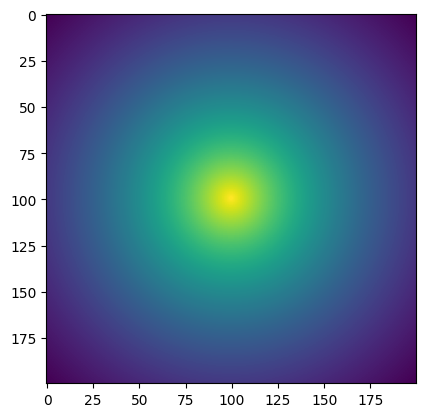

In [155]:
kern = partial(K, σ = 100)
_ = plt.imshow(generate_2d_kernal(kern, (-100, 100, 200), True))

### Trying the ivp Solver

In [156]:
size = 1# 2**10 + 1
hlf_sz = size//2
σe = 1
σi = 1
τ = 0.2
τ_mat = np.array([1,1/τ]).reshape(2,1)

A = np.array([[1,1.5],[1, 0.25]]) # [[a_ee, a_ei],[a_ie, a_ii]]
sub_A = A * np.array([[1,-1], [1,-1]])

Θ = np.array([0.125, 0.4]).reshape(2,1) # [Θe, Θi]

u = np.ones(size) #Plus 1 to have center
v = np.ones(size)
imp_wid = 33 #Width of Impulse
# u[0:imp_wid] = 1 # +1 to capture the center point
w = np.stack([u,v])

out_check = list()

## Get Normalized Kernal
kern_ex = get_normalized_1d_K(size, σe)
kern_in = get_normalized_1d_K(size, σi) 
# KK = np.stack([kern_ex, kern_in], axis=0)
KK = np.stack([np.eye(kern_ex.shape[0]), np.eye(kern_in.shape[0])], axis=0)

#Setup Nonlinear Function
def F(x: np.array, β = 50)->np.array:
    return 1/(1 + np.exp(-β * x))

#Make derv statements
def update(_, w):
    w = w.reshape(2, size)
    x = ((F((sub_A @ (KK @ w.T)[0].T) - Θ) - w) * τ_mat)
    out_check.append(x)
    return x.ravel()

def update2(_,w):
    """Check of the linear algebra solution"""
    w = w.reshape(2, size)
    du = -w[0] + F(A[0,0]*w[0] - A[0,1]*w[1] - Θ[0])
    dv = 1/τ*(-w[1] + F(A[1,0]*w[0] - A[1,1]*w[1] - Θ[1]))
    return np.concatenate((du,dv))

In [157]:
@dataclass
class WCKernelParam:
    A: np.ndarray # [[a_ee, a_ei],[a_ie, a_ii]]
    Θ: np.ndarray # [Θe, Θi]
    τ: np.ndarray # [τe==1, τi]
    F: Callable
    
class WCKernel:
    def __init__(self, u, v, param: WCKernelParam, kernel: Callable):
        self._param = param
        self._init_u = u
        self._init_v = v
        self.kernel = kernel
        self._kernel_mesh = 
        
    def get_kernel_mesh(self):
        if self._kernel_mesh:
            return self.kernel_mesh
        
        # self._kernel_mesh = 
        
    @property
    def inital_u(self):
        return self._init_u

    @property
    def inital_v(self):
        return self._init_v
       
    @property
    def A(self):
        return self._param.A

    @property
    def Θ(self):
        return self._param.Θ
    
    @property
    def τ(self):
        return self._param.τ
    
    @property
    def F(self):
        return self._param.F


In [158]:
test_param = WCKernel(np.array([1]), np.array([1]), np.array([1]), lambda: 1)
test = WCKernel(np.array([1]), np.array([1]), test_param, lambda: 1)

In [159]:
res = scint.solve_ivp(update,(0,10), w.ravel())

In [160]:
out = [res.y[:,i].reshape(2,size)[0] for i in range(len(res.t))]

In [163]:
res

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.072e-01 ...  9.986e+00  1.000e+01]
        y: [[ 1.000e+00  8.983e-01 ...  4.236e-01  4.233e-01]
            [ 1.000e+00  1.000e+00 ...  2.043e-01  2.041e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 716
     njev: 0
      nlu: 0

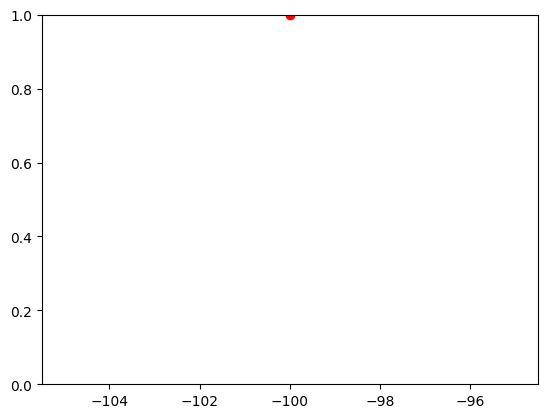

In [162]:
fig, ax = plt.subplots()

line1, = ax.plot(np.linspace(-100, 100, size), out[0], 'ro')
ax.set_ylim(0,1)

def update_gif(i, ln):
    ln.set_data(np.linspace(-100, 100, size), out[i])
    return ln,

anim = FuncAnimation(fig, partial(update_gif, ln=line1), frames=range(len(out)),interval=1000/30)
# anim
HTML(anim.to_html5_video())
# ani.save('test_anim.gif', fps=30)

In [337]:
new_w = w

In [128]:
progress = list()
for _ in range(1):
    progress.append(new_w.copy())
    new_w = new_w.ravel() + update(_,new_w.ravel())

In [184]:
pics = [(x.reshape(size, 1) @ x.reshape(1, size)) for x in out]